## Pre-processing Data

In [1]:
import pandas as pd
import csv
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

def age_model_producer(dataset):
    X = dataset.dropna()
    y = X["Age"]
    x = X.drop(["Age"] , axis = 1 )
    
    
    model = MLPRegressor(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = 0.05, hidden_layer_sizes = (15, 10), max_iter = 1500)
    model.fit(x , y)
    return model
    
def handle_missing_numerical_mean(dataset, column_name):
    
    series = dataset[column_name]
    temp_series = series.dropna()
    temp_array = np.array(temp_series)
    
    mean = temp_array.mean()
    temp_series = series.fillna(mean)
    return (temp_series)

def handle_missing_age(dataset, method = "mean"):
    
    if method == "mean":
        return handle_missing_numerical_mean(dataset, "Age")
    else:
        model = age_model_producer(dataset)
        
        for i in range(dataset.shape[0]):
            if np.isnan(dataset.loc[[i]]["Age"]).values[0]:
                dataset.loc[[i]] = dataset.loc[[i]].fillna(value = model.predict(dataset.loc[[i]].drop(["Age"], axis = 1))[0])
                
        return dataset["Age"]

dataset = pd.read_csv("train.csv")

X = dataset.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)

dummies_sex = pd.get_dummies(X["Sex"])
X["Pclass"] = X["Pclass"].replace(to_replace = [1, 2, 3], value = ["1_pclass", "2_pclass", "3_pclass" ])
dummies_pclass = pd.get_dummies(X["Pclass"])
dummies_embarked = pd.get_dummies(X["Embarked"])


nl = MinMaxScaler()
X[[ "Fare", "SibSp", "Parch"]] = nl.fit_transform(X[[ "Fare" , "SibSp", "Parch"]])


x = X[["Age", "Fare", "SibSp", "Parch"]]
x = pd.concat([x, dummies_sex, dummies_pclass, dummies_embarked], axis = 1)
x["Age"] = handle_missing_age(x, method = "predict")
#x["Age"] = handle_missing_age(X)
x[["Age"]] = nl.fit_transform(x[[ "Age"]])


y = pd.get_dummies(X["Survived"])

## Buliding model of neural network

In [2]:
from sklearn.neural_network import MLPClassifier

data_train, data_test, class_train, class_test = train_test_split(x, y, test_size=0.1)

print(data_train)
model = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = 0.05, hidden_layer_sizes = (15, 10), max_iter = 1500)

          Age      Fare  SibSp     Parch  female  male  1_pclass  2_pclass  \
509  0.321438  0.110272  0.000  0.000000       0     1         0         0   
855  0.220910  0.018250  0.000  0.166667       1     0         0         0   
54   0.811510  0.120975  0.000  0.166667       0     1         1         0   
443  0.346569  0.025374  0.000  0.000000       1     0         0         1   
380  0.522493  0.444099  0.000  0.000000       1     0         1         0   
..        ...       ...    ...       ...     ...   ...       ...       ...   
467  0.698417  0.051822  0.000  0.000000       0     1         1         0   
291  0.233476  0.177775  0.125  0.000000       1     0         1         0   
98   0.421965  0.044893  0.000  0.166667       1     0         0         1   
757  0.220910  0.022447  0.000  0.000000       0     1         0         1   
795  0.484795  0.025374  0.000  0.000000       0     1         0         1   

     3_pclass  C  Q  S  
509         1  0  0  1  
855         1

## Training and Testing model

In [3]:
model.fit(data_train, class_train)
predict = model.predict(data_test)

print("Accuracy : ", accuracy_score(class_test, predict))
print("Mean Square Error : ", mean_squared_error(class_test, predict))

Accuracy :  0.6888888888888889
Mean Square Error :  0.2277777777777778


## Getting average accuracy and error using Cross validate

In [4]:
from sklearn.model_selection import cross_validate

CV = cross_validate(model, x, y, cv=10, scoring=['accuracy', 'neg_mean_squared_error'])

print('Average Accuracy = ', sum(CV['test_accuracy']) / len(CV['test_accuracy']))
print('Average MSE = ', sum(-1 * CV['test_neg_mean_squared_error']) / len(CV['test_neg_mean_squared_error']))

Average Accuracy =  0.7980649188514357
Average MSE =  0.20193508114856423


## Fitting a Categorical Naive Bayes Model
- This model should will be used as a baseline model, not as our final model.
- Extract only categorical values
- encode cateogorical values using OrdinalEncoder function
- split the data
- Create the model, fit the training data, and report the classification report.

In [5]:
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.naive_bayes import CategoricalNB


df_cat = dataset
df_cat = df_cat.drop(['PassengerId', 'Name', 'Ticket','Age','Fare'],axis = 1)
Y = df_cat['Survived']
X_cat = df_cat
X_cat = df_cat.drop(['Survived'],axis = 1)

X_cat['Embarked'] = X_cat['Embarked'].replace(np.nan, 'Unknown',regex = True) # Replace NA's with Unknown 
X_cat['Cabin'] = X_cat['Cabin'].replace(np.nan, 'U',regex = True) # Replace NA's with U
feature_for_encoding = ['Sex','Embarked','Cabin']
print(X_cat.info())

encoder = preprocessing.OrdinalEncoder()
   
for feature in feature_for_encoding:           # encode each of the categorical features 
    temp = X_cat[feature].values.reshape(-1,1)
    encoded = encoder.fit_transform(temp)
    encoded = pd.DataFrame(encoded)
    X_cat[feature] = encoded    
    

X_train,X_Test,Y_train, Y_Test = train_test_split(X_cat,Y, random_state = 1, test_size = .20)

NB = CategoricalNB()
NB.fit(X_train, Y_train)

y_pred = NB.predict(X_Test)

print(classification_report(Y_Test, NB.predict(X_Test)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pclass    891 non-null    int64 
 1   Sex       891 non-null    object
 2   SibSp     891 non-null    int64 
 3   Parch     891 non-null    int64 
 4   Cabin     891 non-null    object
 5   Embarked  891 non-null    object
dtypes: int64(3), object(3)
memory usage: 41.9+ KB
None
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       106
           1       0.71      0.53      0.61        73

    accuracy                           0.72       179
   macro avg       0.72      0.69      0.70       179
weighted avg       0.72      0.72      0.71       179



## Fitting a Decision Tree Model
- Split data into training/testing sets with 80/20 ratio.
- Build model using entrophy as measurement for quality, and choose the best split at each node.
- Fit the training data on this model.
- print classification report for the model.
- print decision tree.

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       106
           1       0.77      0.67      0.72        73

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179



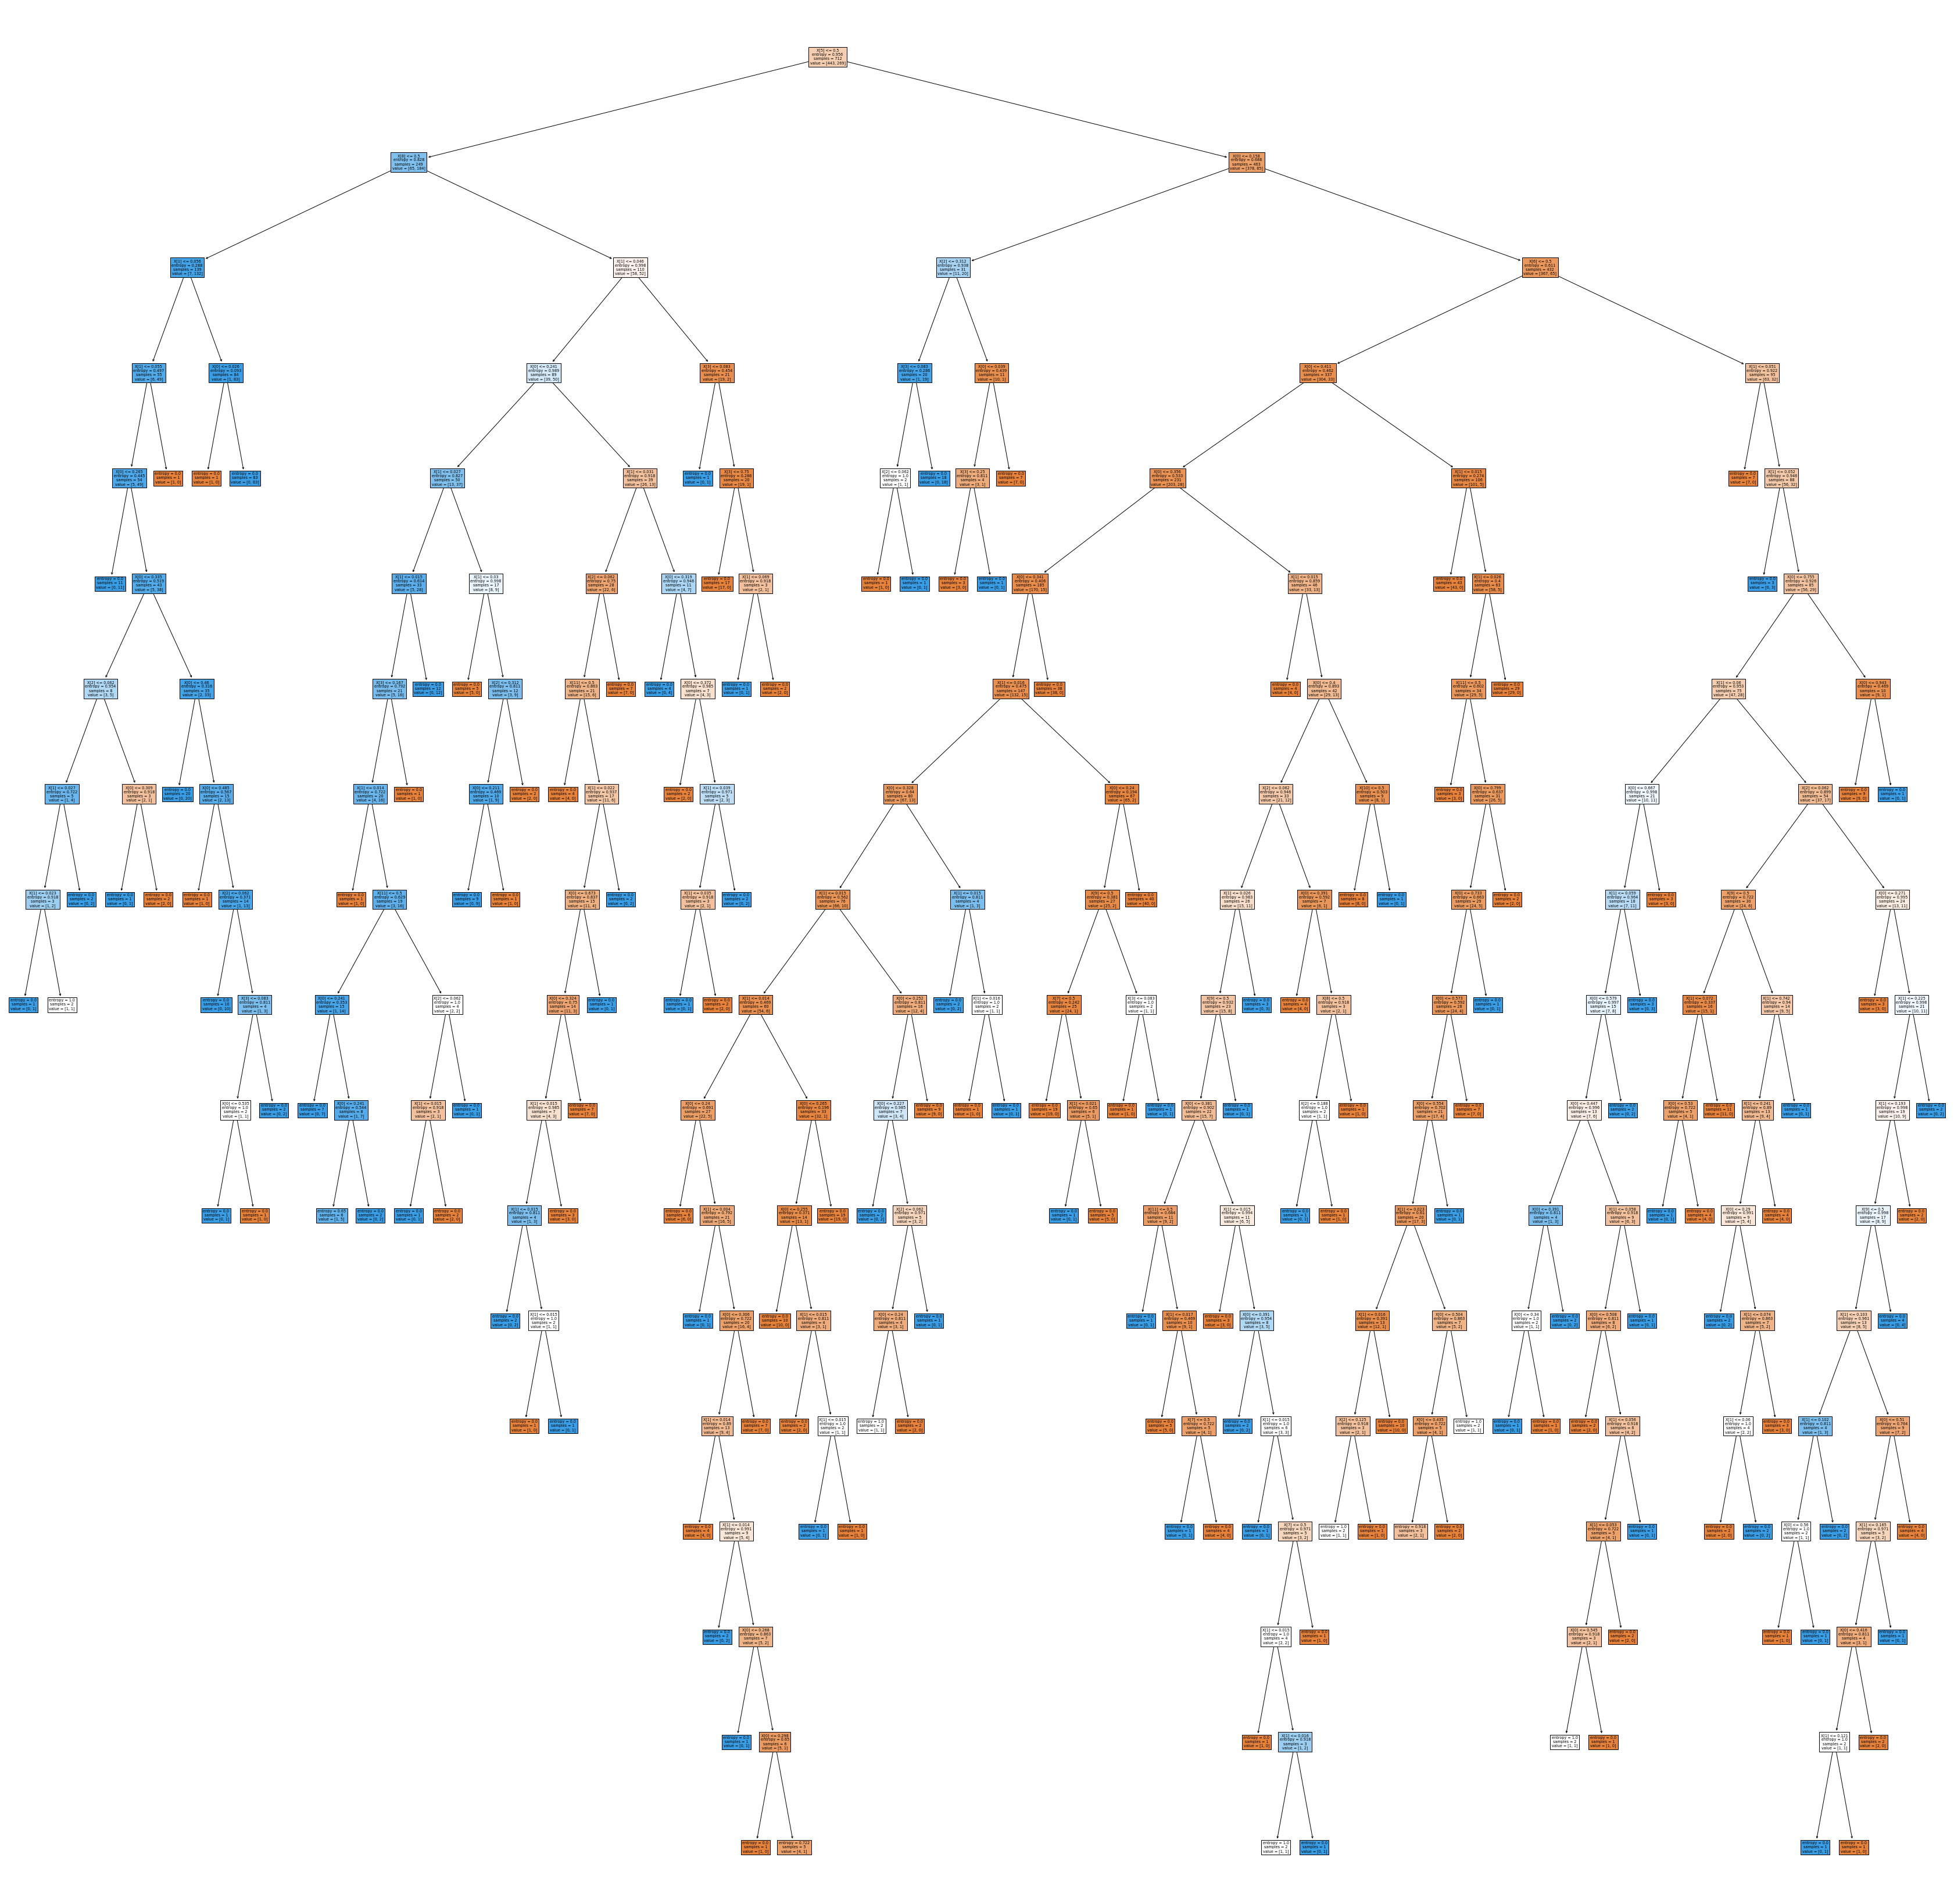

In [6]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

X_train,X_Test,Y_train, Y_Test = train_test_split(x,Y, random_state = 1, test_size = .20)


model=DecisionTreeClassifier(criterion='entropy', splitter='best', random_state = 1) 
model.fit(X_train,Y_train)
y_Tree_pred=model.predict(X_Test)

print(classification_report(Y_Test, model.predict(X_Test)))

plt.figure(figsize=(60,60))
tree.plot_tree(model,filled=True)
plt.show()

## Pre-Pruning The Tree Model
- Set a dictionary with a list of maximum depth values
- Run GridSearch on these values, and report the model with the best average score
- Extract model, fit training data, and print classification report
- Print pruned tree

Best Parameter: {'max_depth': 6}
Best parameters score: 0.8301056338028168
              precision    recall  f1-score   support

           0       0.74      0.93      0.83       106
           1       0.85      0.53      0.66        73

    accuracy                           0.77       179
   macro avg       0.80      0.73      0.74       179
weighted avg       0.79      0.77      0.76       179



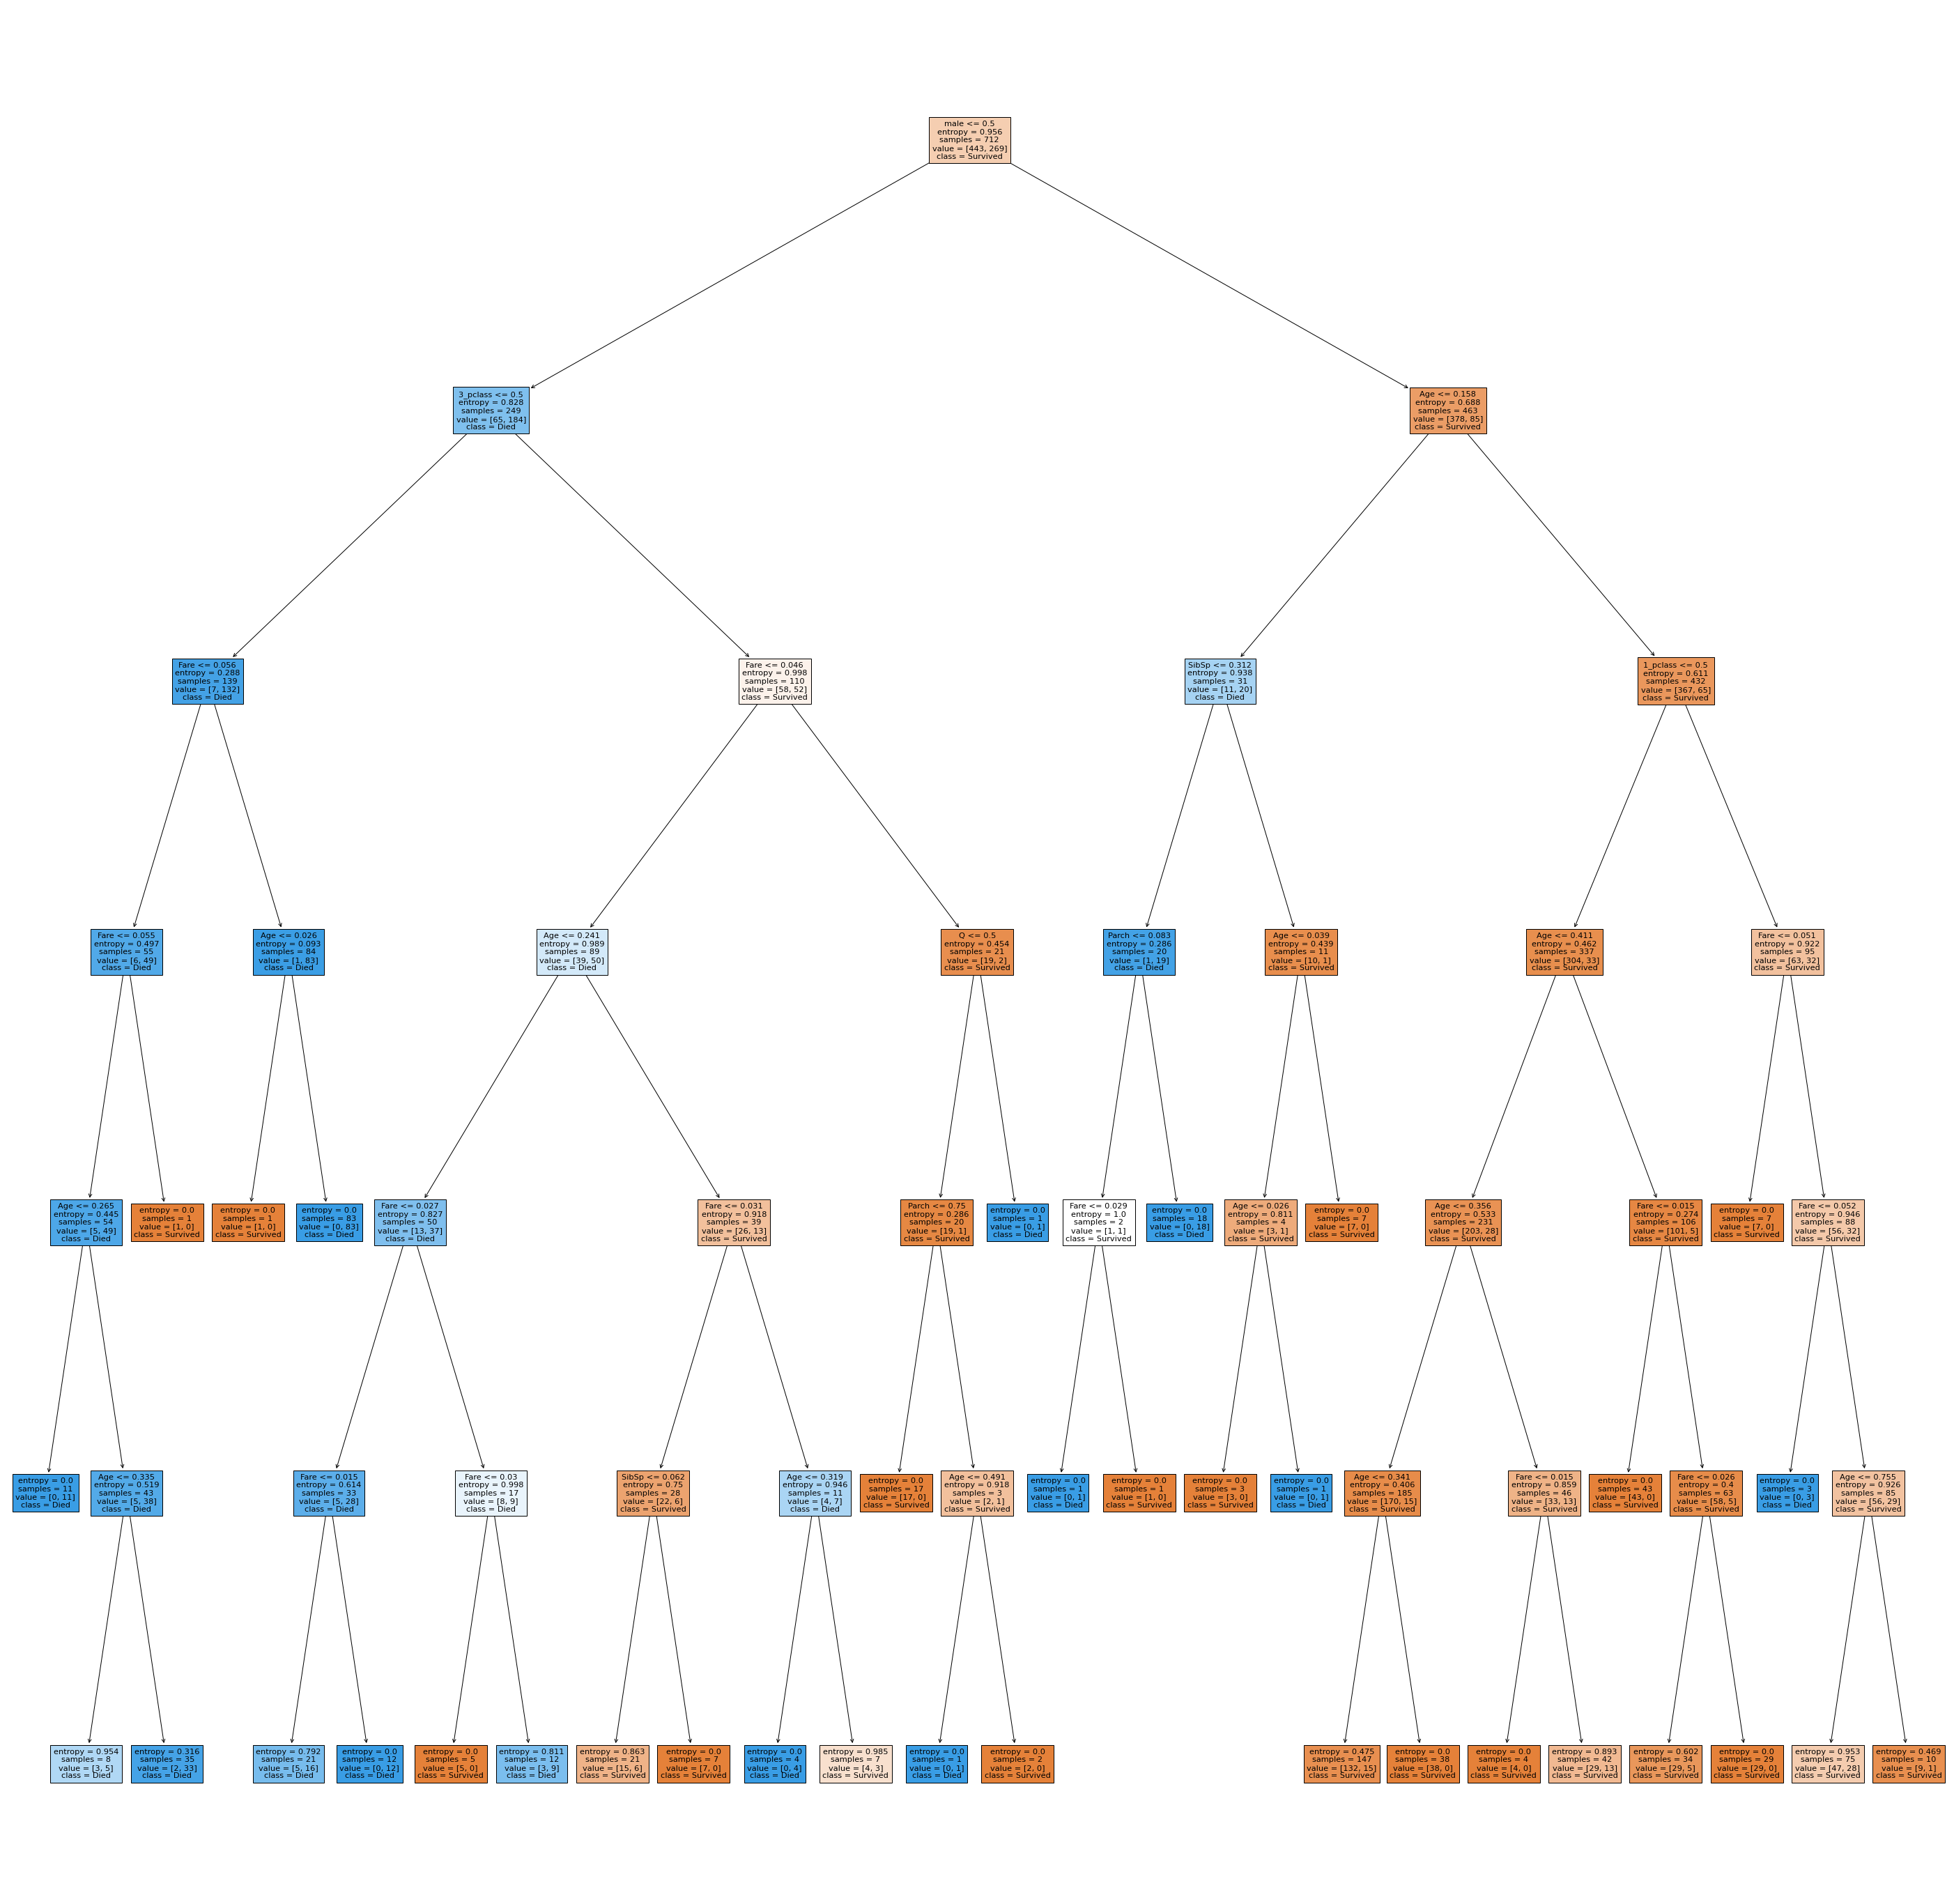

In [7]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

parameters = {'max_depth': [6,8,10,12,14]} #Dictionary with a list of different depths to be tested

gs_cv = GridSearchCV(estimator=model,param_grid=parameters,cv = 10,n_jobs=-1) # Grid search with 10 kfolds
gs_cv.fit(X_train,Y_train)

mod = gs_cv.best_estimator_ # Extract best model
params = gs_cv.best_params_ # Extract paramaters from best model
score = gs_cv.best_score_ # Extract average score from best model


print(f"Best Parameter: {params}")
print(f"Best parameters score: {score}")
print(classification_report(Y_Test, gs_cv.predict(X_Test)))


classes = ['Survived','Died']
features = ['Age','Fare','SibSp','Parch','female','male',"1_pclass", "2_pclass",
            "3_pclass",'C','Q','S']
plt.figure(figsize=(50,50))
tree.plot_tree(mod,class_names=classes,feature_names = features,filled=True)
plt.show()

## *BONUS MODEL* : RF with grid hyperparameter search

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

params = {'n_estimators':(100, 300, 500,1000), 'criterion':('gini', 'entropy'),'min_samples_split':[2, 11],'min_samples_leaf':[1, 9]}


gridSearch = GridSearchCV(RandomForestClassifier(random_state = 1), param_grid=params, cv=10,n_jobs=-1)
gridSearch.fit(X_train,Y_train)

params = gridSearch.best_params_
score = gridSearch.best_score_

print(f"Best Parameter: {params}")
print(f"Best parameters score: {score}")

print(classification_report(Y_Test, gridSearch.best_estimator_.predict(X_Test)))


Best Parameter: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 500}
Best parameters score: 0.8413536776212833
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       106
           1       0.79      0.58      0.67        73

    accuracy                           0.77       179
   macro avg       0.77      0.74      0.74       179
weighted avg       0.77      0.77      0.76       179

